In [1]:
!pwd

/local/workspace/hailo_virtualenv/lib/python3.8/site-packages/hailo_tutorials/notebooks


In [2]:
!hailortcli --version

HailoRT-CLI version 4.14.0


In [3]:
%matplotlib inline
import tensorflow as tf

from IPython.display import SVG
from hailo_sdk_client import ClientRunner

In [4]:
# importing everything needed
%matplotlib inline
import os
import json
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.patches as patches

from IPython.display import SVG
from IPython.display import display
from matplotlib import pyplot as plt
from PIL import Image
from hailo_sdk_client import ClientRunner, InferenceContext

In [5]:
workpath = '/local/shared_with_docker/'
onnx_path = workpath + 'yolov5m_coco_10class.onnx'
onnx_model_name = 'yolov5m_coco_10class'

runner = ClientRunner(hw_arch='hailo8')
hn, npz = runner.translate_onnx_model(onnx_path, onnx_model_name,
                                      start_node_names=['images'],
                                      end_node_names=["/model.24/m.0/Conv","/model.24/m.1/Conv","/model.24/m.2/Conv"],
                                      net_input_shapes={'images':[1, 3, 512, 512]})

[info] NMS structure of yolov5 (or equivalent architecture) was detected, a generated config file will be saved inside the har. To add NMS postprocessing to the model, please use the command: nms_postprocess(meta_arch=yolov5).
[info] Translation completed on ONNX model yolov5m_coco_10class
[info] Initialized runner for yolov5m_coco_10class


In [6]:
from tensorflow.python.eager.context import eager_mode

def preproc(image, output_height=512, output_width=512, resize_side=512):
    with eager_mode():
        h, w = image.shape[0], image.shape[1]
        scale = tf.cond(tf.less(h, w), lambda: resize_side / h, lambda: resize_side / w)
        resized_image = tf.compat.v1.image.resize_bilinear(tf.expand_dims(image, 0), [int(h*scale), int(w*scale)])
        cropped_image = tf.compat.v1.image.resize_with_crop_or_pad(resized_image, output_height, output_width)
        return tf.squeeze(cropped_image)

In [7]:
images_path = workpath+'dataset/coco_10class/'
images_list = [img_name for img_name in os.listdir(images_path) if
               os.path.splitext(img_name)[1] == '.jpg']
calib_dataset = np.zeros((len(images_list), 512, 512, 3), dtype=np.float32)

In [8]:
for idx, img_name in enumerate(sorted(images_list)):
    img = np.array(Image.open(os.path.join(images_path, img_name)))
    img = img[:,:,:3]
    img_preproc = preproc(img)
    calib_dataset[idx,:,:,:] = img_preproc.numpy().astype(np.uint8)

np.save(images_path+'calib_set.npy', calib_dataset)

PermissionError: [Errno 13] Permission denied: '/local/shared_with_docker/dataset/coco_10class/calib_set.npy'

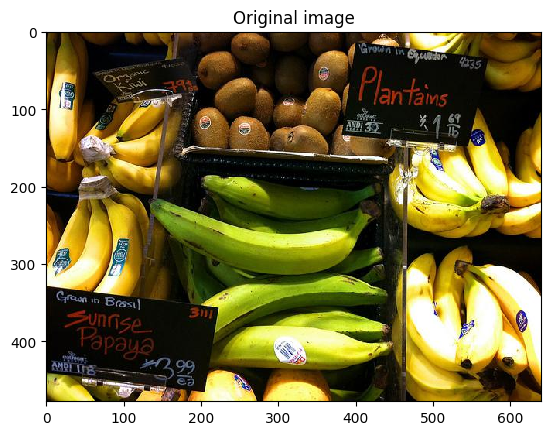

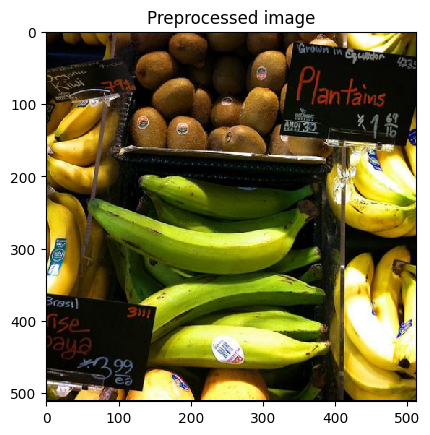

187

In [9]:
plt.imshow(img, interpolation='nearest')
plt.title('Original image')
plt.show()
plt.imshow(np.array(calib_dataset[idx,:,:,:], np.uint16), interpolation='nearest')
plt.title('Preprocessed image')
plt.show()
len(calib_dataset)

In [10]:
alls_lines_yolo= [
    'normalization1 = normalization([0.0, 0.0, 0.0], [255.0, 255.0, 255.0])\n',
    'nms_postprocess(meta_arch=yolo, image_dims=[512, 512], classes=6)\n'
#    'nms_postprocess("/local/shared_with_docker/nms_config_yolov5_boat.json", meta_arch=yolov5)\n',
#   'nms_postprocess(meta_arch=yolov5, engine=auto)\n'
    'change_output_activation(sigmoid)\n',
    'model_optimization_config(calibration,batch_size=4,calibset_size=150)\n',
    # 'post_quantization_optimization(bias_correction, policy=enabled)\n',
    'post_quantization_optimization(bias_correction, policy=disabled)\n',
    'post_quantization_optimization(finetune,policy=disabled)\n',
    'compilation_param({conv*}, balance_output_multisplit=False)\n',
    # 'compilation_param(conv1, balance_output_multisplit=True)\n',
    'allocator_param(automatic_ddr=True)\n',
    #'platform_param(targets=[ethernet])\n',
    #'resources_param(strategy=greedy, max_control_utilization=0.9, max_compute_utilization=0.9, max_memory_utilization=0.9)\n',
    'context_switch_param(mode=enabled)\n',
    #'performance_param(fps=240)'
]

# Save the commands in an .alls file, this is the Model Script
open('yolo_script_cpu.alls','w').writelines(alls_lines_yolo)

# Load the model script to ClientRunner so it will be considered on optimization
runner.load_model_script('yolo_script_cpu.alls')

runner.optimize(calib_dataset)
#hn_layers = runner1.get_hn_dict()['layers']
#print([layer for layer in hn_layers if hn_layers[layer]['type'] == 'input_layer']) # See available input layer names

[info] Loading model script to yolov5m_coco_10class from yolo_script_cpu.alls
[info] Starting Model Optimization


2024-06-24 17:07:06.967295: F tensorflow/stream_executor/cuda/cuda_driver.cc:152] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error


[warning] Reducing optimization level to 1 (the accuracy won't be optimized and compression won't be used) because there's less data than the recommended amount (1024)
[info] Using dataset with 150 entries for calibration


2024-06-24 17:07:07.618130: F tensorflow/stream_executor/cuda/cuda_driver.cc:152] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error


[info] Starting Stats Collector


Calibration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:43<00:00,  3.44entries/s]


[info] Stats Collector is done (completion time is 00:00:44.35)


2024-06-24 17:08:08.007431: F tensorflow/stream_executor/cuda/cuda_driver.cc:152] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error


[info] Bias Correction skipped
[info] Adaround skipped
[info] Fine Tune skipped


2024-06-24 17:08:08.908098: F tensorflow/stream_executor/cuda/cuda_driver.cc:152] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error


[info] Starting Layer Noise Analysis


Full Quant Analysis (W/ SNR model): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.32s/iterations]


[info] Layer Noise Analysis is done (completion time is 00:00:56.82)
[info] Model Optimization is done


In [11]:
hef = runner.compile()

file_name = workpath + 'hef/' + onnx_model_name + '.hef'
with open(file_name, 'wb') as f:
    f.write(hef)

[info] Loading network parameters
[info] Starting Hailo allocation and compilation flow
	
[info] Using Multi-context flow
[info] Resources optimization guidelines: Strategy -> GREEDY Objective -> MAX_FPS
[info] Resources optimization params: max_control_utilization=60%, max_compute_utilization=60%, max_memory_utilization (weights)=60%, max_input_aligner_utilization=60%, max_apu_utilization=60%
[info] input_layer1: Pass
[info] ew_add1: Pass
[info] normalization1: Pass
[info] ew_add2: Pass
[info] conv17: Pass
[info] concat1: Pass
[info] conv7: Pass
[info] conv11: Pass
[info] conv13: Pass
[info] conv15: Pass
[info] conv5: Pass
[info] conv19: Pass
[info] conv4: Pass
[info] ew_add4: Pass
[info] ew_add5: Pass
[info] ew_add6: Pass
[info] conv9: Pass
[info] ew_add3: Pass
[info] ew_add7: Pass
[info] conv12: Pass
[info] conv1_sd0_defuse_width_feature_reshape: Pass
[info] conv25: Pass
[info] conv1_sd1_defuse_width_feature_reshape: Pass
[info] conv3: Pass
[info] conv21: Pass
[info] conv27: Pass
[i

[info] Context:0/3 Iteration 0: Trying parallel splits...   
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0                                                                                                  
 worker1                                                                                                  
 worker2                                                                                                  
 worker3                                                                                                  

  00:00
[info] Context:0/3 Iteration 0: Trying parallel splits...   
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0                                                                                                  
 worker1                                                                                                  
 worker2  *  

[info] Context:0/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          *          *          *          *          *          V       
 worker1  *          *          *          *          *          *          *          *          V       
 worker2  V          V          V          V          V          *          V          V          V       
 worker3  *          *          *          *          *          *          *          *          V       

  00:01
[info] Context:0/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          V          *          V          *          *          *          V       
 worker1  *          *          *          *          *          *          *          *          V       
 worker2  V  

[info] Context:1/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          *          *          *          *          *          V       
 worker1  *          *          *          *          *          *          *          *          V       
 worker2  *          *          *          *          *          *          *          *          V       
 worker3                                                                                                  

  00:06
[info] Context:1/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          V          *          *          *          *          *          *          V       
 worker1  *          *          *          *          *          *          *          *          V       
 worker2  *  

[info] Context:1/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          V          *          V          V          V          V          *          V       
 worker1  V          V          V          *          V          *          V          V          V       
 worker2  V          V          V          *          V          *          V          *          V       
 worker3  V          V          *          V          V          *          V          V          V       

  00:07
[info] Context:1/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          V          *          V          V          V          V          *          V       
 worker1  V          V          V          *          V          *          V          V          V       
 worker2  V  

[info] Context:2/3 Iteration 0: Trying parallel splits...   
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0                                                                                                  
 worker1                                                                                                  
 worker2  *          *          *          *          *          *          *          *          V       
 worker3  *          *          *          *          *          *          *          *          V       

  00:21
[info] Context:2/3 Iteration 0: Trying parallel splits...   
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0                                                                                                  
 worker1                                                                                                  
 worker2  *  

[info] Context:2/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          *          *          *          *          *          V       
 worker1  *          V          V          V          *          *          V          *          V       
 worker2  V          V          *          *          *          *          *          *          V       
 worker3  V          V          *          V          V          V          *          V          V       

  00:21
[info] Context:2/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          *          *          *          *          *          V       
 worker1  *          V          V          V          *          *          V          *          V       
 worker2  V  

[info] Context:2/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          V          V          V          *          V          V       
 worker1  V          V          V          V          V          V          V          V          V       
 worker2  V          V          V          V          *          V          V          *          V       
 worker3  V          V          V          V          V          V          V          V          V       

  00:23
[info] Context:2/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          V          V          V          *          V          V       
 worker1  V          V          V          V          V          V          V          V          V       
 worker2  V  

[info] Context:3/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          *          *          *          *          *          V       
 worker1  *          V          V          *          V          V          V          *          V       
 worker2  *          V          V          V          *          V          V          V          V       
 worker3  *          *          *          *          *          *          *          *          V       

  00:32
[info] Context:3/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          *          *          *          *          *          V       
 worker1  *          V          V          *          V          V          V          *          V       
 worker2  *  

[info] Context:3/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  V          V          V          V          V          V          V          V          V       
 worker1  V          V          V          V          V          V          V          V          V       
 worker2  *          V          V          V          V          V          V          V          V       
 worker3  V          V          V          V          V          *          V          V          V       

  00:34
[info] Context:3/3 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  V          V          V          V          V          V          V          V          V       
 worker1  V          V          V          V          V          V          V          V          V       
 worker2  V  